In [1]:
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import sem
from cpsplines.mosek_functions.interval_constraints import IntConstraints
from cpsplines.psplines.bspline_basis import BsplineBasis
from cpsplines.psplines.penalty_matrix import PenaltyMatrix
from cpsplines.fittings.fit_cpsplines import CPsplines
from cpsplines.utils.gcv import GCV
import statsmodels.genmod.families.family
import mosek.fusion as mf

from Functions import poly

from Functions import simpleGCV
from Functions import choose_lambda
from Functions import simpson_spline_full
from Functions import simpson_spline_matrices
from Functions import intGCV
from Functions import choose_lambda_int
from Functions import create_obj_mat
from Functions import unconstrained_sof_fit
from Functions import cp_sof_fit
import time
from scipy.stats import norm
from scipy.stats import pareto

In [6]:

# betaT = beta(T)
#weights. 1/3 for the limits, 2/3 for the odd subintervals, 4/3 for the even ones. 

w = [1/3] + [4/3 if i%2==0 else 2/3 for i in range(2,501)] + [1/3]
W = 1/501* np.diag(w)
T = np.linspace(0.05, 1, num=50)
T2 = np.linspace(0.05,  1, num=501)
betaT=pd.read_csv("beta.csv", header=None )
betaT=np.array(betaT).squeeze()
betaT2=pd.read_csv("beta2.csv", header=None )
betaT2=np.array(betaT2).squeeze()

## ERROR SIGUE UNA $N(0, 0.01)$

In [3]:
imse_cons_pareto_nonneg_ellos=np.array([10.75196, 10.43598,  9.63650, 10.51186, 10.07906, 10.71476, 10.81782, 10.35835, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646,
10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436,
10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140,
10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536,
10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034,
10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646,
10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436,
10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140,
10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536,
10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034, 10.13646, 10.25436, 10.48140, 10.92536, 10.43034])


mse_cons_pareto_nonneg_ellos =np.array([ 0.3319387, 0.3192479, 0.2548696, 0.3250896, 0.2967607, 0.3029809, 0.3365828, 0.3413915, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346,
0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043,
0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677,
0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079,
0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789,
0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346,
0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043,
0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677,
0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079,
0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789,
0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789, 0.2970079, 0.3095677, 0.3374043, 0.3246346, 0.3374789])


imse_uncons_pareto_nonneg_ellos = np.array([ 0.03225741, 0.02885842, 0.02805617, 0.03297895, 0.03098248, 0.02966226, 0.03183103, 0.02901712, 0.03297895, 0.03098248, 0.02966226,
0.03183103, 0.02901712, 0.03297895, 0.03098248, 0.02966226, 0.03183103, 0.02901712, 0.03297895, 0.03098248, 0.02966226, 0.03183103,
0.02901712, 0.03297895, 0.03098248, 0.02966226, 0.03183103, 0.02901712, 0.03297895, 0.03098248, 0.02966226, 0.03183103, 0.02901712,
0.03297895, 0.03098248, 0.02966226, 0.03183103, 0.02901712, 0.03297895, 0.03098248, 0.02966226, 0.03183103, 0.02901712, 0.03297895,
0.03098248, 0.02966226, 0.03183103, 0.02901712, 0.03297895, 0.03098248, 0.02966226, 0.03183103, 0.02901712, 0.03297895, 0.03098248,
0.02966226, 0.03183103, 0.02901712, 0.03297895, 0.03098248, 0.02966226, 0.03183103, 0.02901712, 0.03297895, 0.03098248, 0.02966226,
0.03183103, 0.02901712, 0.03297895, 0.03098248, 0.02966226, 0.03183103, 0.02901712, 0.03297895, 0.03098248, 0.02966226, 0.03183103,
0.02901712, 0.03297895, 0.03098248, 0.02966226, 0.03183103, 0.02901712, 0.03297895, 0.03098248, 0.02966226, 0.03183103, 0.02901712,
0.03297895, 0.03098248, 0.02966226, 0.03183103, 0.02901712, 0.03297895, 0.03098248, 0.02966226, 0.03183103, 0.02901712, 0.03297895,
0.03098248, 0.02966226, 0.03183103, 0.02901712, 0.03297895, 0.03098248, 0.02966226, 0.03183103, 0.02901712, 0.03297895, 0.03098248,
0.02966226, 0.03183103, 0.02901712, 0.03297895, 0.03098248, 0.02966226, 0.03183103, 0.02901712, 0.03297895, 0.03098248, 0.02966226,
0.03183103, 0.02901712, 0.03297895, 0.03098248, 0.02966226, 0.03183103, 0.02901712, 0.03297895, 0.03098248, 0.02966226, 0.03183103,
0.02901712, 0.03297895, 0.03098248, 0.02966226, 0.03183103, 0.02901712, 0.03297895, 0.03098248, 0.02966226, 0.03183103, 0.02901712,
0.03297895, 0.03098248, 0.02966226, 0.03183103, 0.02901712, 0.03297895, 0.03098248, 0.02966226, 0.03183103, 0.02901712, 0.03297895,
0.03098248, 0.02966226, 0.03183103, 0.02901712, 0.03297895, 0.03098248, 0.02966226, 0.03183103, 0.02901712, 0.03297895, 0.03098248,
0.02966226, 0.03183103, 0.02901712, 0.03297895, 0.03098248, 0.02966226, 0.03183103, 0.02901712, 0.03297895, 0.03098248, 0.02966226,
0.03183103, 0.02901712, 0.03297895, 0.03098248, 0.02966226, 0.03183103, 0.02901712, 0.03297895, 0.03098248, 0.02966226, 0.03183103,
0.02901712, 0.03297895, 0.03098248, 0.02966226, 0.03183103, 0.02901712, 0.03297895, 0.03098248, 0.02966226, 0.03183103, 0.02901712,
0.03297895, 0.03098248])

mse_uncons_pareto_nonneg_ellos = np.array([ 0.08971947, 0.08581602, 0.07776280, 0.06421479, 0.07520622, 0.07922666, 0.07890139, 0.07933972, 0.06421479, 0.07520622, 0.07922666,
0.07890139, 0.07933972, 0.06421479, 0.07520622, 0.07922666, 0.07890139, 0.07933972, 0.06421479, 0.07520622, 0.07922666, 0.07890139,
0.07933972, 0.06421479, 0.07520622, 0.07922666, 0.07890139, 0.07933972, 0.06421479, 0.07520622, 0.07922666, 0.07890139, 0.07933972,
0.06421479, 0.07520622, 0.07922666, 0.07890139, 0.07933972, 0.06421479, 0.07520622, 0.07922666, 0.07890139, 0.07933972, 0.06421479,
0.07520622, 0.07922666, 0.07890139, 0.07933972, 0.06421479, 0.07520622, 0.07922666, 0.07890139, 0.07933972, 0.06421479, 0.07520622,
0.07922666, 0.07890139, 0.07933972, 0.06421479, 0.07520622, 0.07922666, 0.07890139, 0.07933972, 0.06421479, 0.07520622, 0.07922666,
0.07890139, 0.07933972, 0.06421479, 0.07520622, 0.07922666, 0.07890139, 0.07933972, 0.06421479, 0.07520622, 0.07922666, 0.07890139,
0.07933972, 0.06421479, 0.07520622, 0.07922666, 0.07890139, 0.07933972, 0.06421479, 0.07520622, 0.07922666, 0.07890139, 0.07933972,
0.06421479, 0.07520622, 0.07922666, 0.07890139, 0.07933972, 0.06421479, 0.07520622, 0.07922666, 0.07890139, 0.07933972, 0.06421479,
0.07520622, 0.07922666, 0.07890139, 0.07933972, 0.06421479, 0.07520622, 0.07922666, 0.07890139, 0.07933972, 0.06421479, 0.07520622,
0.07922666, 0.07890139, 0.07933972, 0.06421479, 0.07520622, 0.07922666, 0.07890139, 0.07933972, 0.06421479, 0.07520622, 0.07922666,
0.07890139, 0.07933972, 0.06421479, 0.07520622, 0.07922666, 0.07890139, 0.07933972, 0.06421479, 0.07520622, 0.07922666, 0.07890139,
0.07933972, 0.06421479, 0.07520622, 0.07922666, 0.07890139, 0.07933972, 0.06421479, 0.07520622, 0.07922666, 0.07890139, 0.07933972,
0.06421479, 0.07520622, 0.07922666, 0.07890139, 0.07933972, 0.06421479, 0.07520622, 0.07922666, 0.07890139, 0.07933972, 0.06421479,
0.07520622, 0.07922666, 0.07890139, 0.07933972, 0.06421479, 0.07520622, 0.07922666, 0.07890139, 0.07933972, 0.06421479, 0.07520622,
0.07922666, 0.07890139, 0.07933972, 0.06421479, 0.07520622, 0.07922666, 0.07890139, 0.07933972, 0.06421479, 0.07520622, 0.07922666,
0.07890139, 0.07933972, 0.06421479, 0.07520622, 0.07922666, 0.07890139, 0.07933972, 0.06421479, 0.07520622, 0.07922666, 0.07890139,
0.07933972, 0.06421479, 0.07520622, 0.07922666, 0.07890139, 0.07933972, 0.06421479, 0.07520622, 0.07922666, 0.07890139, 0.07933972,
0.06421479, 0.07520622])

In [4]:
import warnings
warnings.filterwarnings('ignore')

IMSE for N= 35 9.305564532987937
MSE for N= 35 2.869929834841925
Standard deviation of the IMSE: 0.2731528048680047
Standard deviation of the MSE: 0.14028585738562294
IMSE for N= 75 7.737412576236897
MSE for N= 75 1.9696675463679596
Standard deviation of the IMSE: 0.23220898497709078
Standard deviation of the MSE: 0.014813481359613703
IMSE for N= 125 10.771393363852141
MSE for N= 125 1.3070521406591369
Standard deviation of the IMSE: 0.15761580056292238
Standard deviation of the MSE: 0.10905248323152202


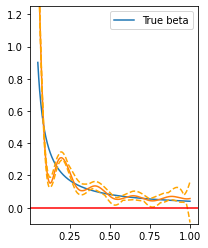

Times [ 83.22009563 168.4690485  242.98011565]


In [7]:
############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 200

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_unconstrained = np.zeros(3)

IMSE_uncons=np.zeros(n_sims)
MSE_uncons=np.zeros(n_sims)

cont=0
for N in [35, 75, 125]:
    start_time = time.time()

    for i in range(n_sims):
        #Trabajaremos con estos datos
        
        ssss="_".join(['X', str(i+1), str(N)])
        tttt="_".join(['y', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)

        
        y_hat, betagorro = unconstrained_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, plot=False)
        #plt.figure(figsize=(3,4))
        #plt.plot(T2, betaT2, label = 'True beta')
        #plt.plot(T2,betagorro, label=f'approx {i+1}')
        #plt.axhline(0, color='red')
        #plt.ylim([-0.2, 1])
        #plt.legend()
        #plt.show()
        #plt.figure(figsize=(3,4))
        #plt.plot(np.linspace(0,1, num=len(y)), y, label = 'True y')
        #plt.plot(np.linspace(0,1, num=len(y_hat)), y_hat, label=f'approx {i+1}')
        #plt.axhline(0, color='red')
        #plt.ylim([0.05, 0.3])
        #plt.legend()
        #plt.show()
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE_uncons[i] = (W @ (betaT2-betagorro)**2).sum()
        MSE_uncons[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=',N,  IMSE_uncons.sum()/n_sims*1000)
    print('MSE for N=',N,  MSE_uncons.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE_uncons*1000))
    print('Standard deviation of the MSE:', sem(MSE_uncons*1000))
    end_time = time.time()
    time_unconstrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red')
plt.ylim([-0.1, 1.25])
plt.legend()
plt.show()
print('Times', time_unconstrained)

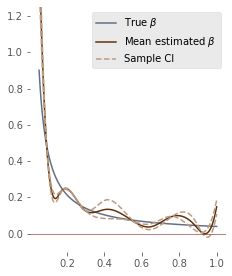

In [19]:
plt.figure(figsize=(3.5,4.5))
plt.plot(T2, betaT2, label = r"True $\beta $", color='#666E86')
plt.plot(T2,mean_fitted_vals, label=r"Mean estimated $\beta $", color='#5F3108')
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='#B99B81', label='Sample CI')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='#B99B81')
# Plot a horizontal line at y=0
plt.axhline(0, color='#780000', linewidth=0.5)
plt.ylim([-0.1, 1.25])
plt.legend()
plt.style.use('ggplot')
plt.box(False)
plt.savefig('pareto_uncons005.png', transparent=True)
plt.show()

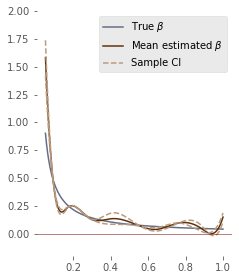

In [20]:
plt.figure(figsize=(3.5,4.5))
plt.plot(T2, betaT2, label = r"True $\beta $", color='#666E86')
plt.plot(T2,mean_fitted_vals, label=r"Mean estimated $\beta $", color='#5F3108')
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='#B99B81', label='Sample CI')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='#B99B81')
# Plot a horizontal line at y=0
plt.axhline(0, color='#780000', linewidth=0.5)
plt.ylim([-0.2, 2])
plt.legend()
plt.style.use('ggplot')
plt.box(False)
plt.savefig('ccccccccccccccc0.png', transparent=True)
plt.show()

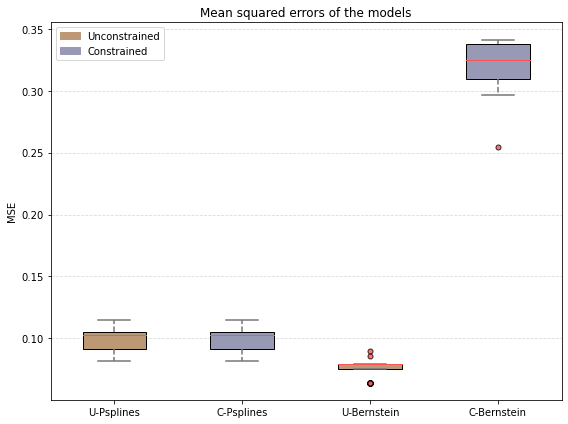

In [50]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Generate random data
np.random.seed(1)


# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Customize boxplot colors
box_colors = ['#BC9874', '#9899B5', '#BC9874', '#9899B5']
box_labels = ['U-Psplines', 'C-Psplines', 'U-Bernstein', 'C-Bernstein']
legend_labels = ['Unconstrained', 'Constrained']
# Create boxplot
boxplot = ax.boxplot([MSE_cons*1000, MSE_uncons*1000, mse_uncons_pareto_nonneg_ellos, mse_cons_pareto_nonneg_ellos,], patch_artist=True, widths=0.5)

# Set boxplot style
for patch, color in zip(boxplot['boxes'], box_colors):
    patch.set_facecolor(color)

# Set whisker and cap style
for whisker, cap in zip(boxplot['whiskers'], boxplot['caps']):
    whisker.set(color='#757575', linewidth=1.5, linestyle='--')
    cap.set(color='#757575', linewidth=1.5)

# Set median line style
for median in boxplot['medians']:
    median.set(color='#FF5252', linewidth=1)

# Set outliers style
for flier in boxplot['fliers']:
    flier.set(marker='o', markersize=5, markerfacecolor='#FF5252', alpha=0.8)

# Create custom legend
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(box_colors, legend_labels)]
legend_patchess = [legend_patches[0], legend_patches[1]]
ax.legend(handles=legend_patchess, loc='upper left')

# Set axis labels and title
ax.set_xticklabels(box_labels)
ax.set_ylabel('MSE')
ax.set_title('Mean squared errors of the models')

# Customize grid appearance
ax.yaxis.grid(True, linestyle='--', which='major', color='lightgrey', alpha=0.8)

# Adjust the plot layout
fig.tight_layout()
plt.box(True)
plt.savefig('paretitomse.png', transparent=True)
# Show the plot
plt.show()

### Cálculo del IMSE y del MSE

IMSE for N= 35 8.241736810257875
MSE for N= 35 3.2987473026808067
Standard deviation of the IMSE: 0.2694605753503615
Standard deviation of the MSE: 0.15853264966570776
IMSE for N= 75 6.32146877928947
MSE for N= 75 2.0639194087132577
Standard deviation of the IMSE: 0.22108997969788405
Standard deviation of the MSE: 0.010706186818511574
IMSE for N= 125 9.378385882034587
MSE for N= 125 1.3259978727229775
Standard deviation of the IMSE: 0.15389519714152103
Standard deviation of the MSE: 0.10948084855064312


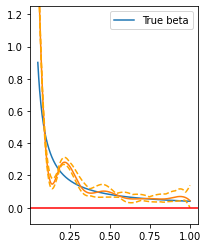

Times [ 83.58015943 158.18874502 235.34277654]


In [8]:
#############################################################################
#ESTO PARA NUESTRO PROBLEMA
np.random.seed(1)
n_sims = 200

fitted_means_matrix = np.zeros((n_sims, 501))
lower_ci_matrix = np.zeros((n_sims, 501))
upper_ci_matrix = np.zeros((n_sims, 501))

time_constrained = np.zeros(3)

IMSE_cons=np.zeros(n_sims)
MSE_cons=np.zeros(n_sims)

cont=0
for N in [35,75,125]:
    start_time = time.time()
    for i in range(n_sims):
        #Trabajaremos con estos datos
        ssss="_".join(['X', str(i+1), str(N)])
        tttt="_".join(['y', str(i+1), str(N)])
        X = pd.read_csv("".join([ssss,'.csv']), header=None )
        y = pd.read_csv("".join([tttt,'.csv']), header=None )
        y=np.array(y).squeeze()
        X=np.array(X)
        
        y_hat, theta0, betagorro = cp_sof_fit(X=X, y=y, k=15, initial_grid=T, newgrid_size=501, derivative_order=0, sign='+', sign_threshold=0.0,  plot=False)
        # Store fitted values in matrix
        fitted_means_matrix[i,:] = betagorro.reshape((501,))
    
        #IMSE
        IMSE_cons[i] = (W @ (betaT2-betagorro)**2).sum()
        #MSE
        MSE_cons[i] = np.mean((y-y_hat)**2)
    print('IMSE for N=',N,  IMSE_cons.sum()/n_sims*1000)
    print('MSE for N=',N,  MSE_cons.sum()/n_sims*1000)
    print('Standard deviation of the IMSE:', sem(IMSE_cons*1000))
    print('Standard deviation of the MSE:', sem(MSE_cons*1000))
    end_time = time.time()
    time_constrained[cont] = end_time - start_time
    cont+=1
mean_fitted_vals = np.mean(fitted_means_matrix, axis=0)
mean_lower_ci = np.quantile(fitted_means_matrix, 0.025, axis=0)
mean_upper_ci = np.quantile(fitted_means_matrix, 0.975, axis=0)

plt.figure(figsize=(3,4))
plt.plot(T2, betaT2, label = 'True beta')
plt.plot(T2,mean_fitted_vals)
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='orange')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='orange')
# Plot a horizontal line at y=0
plt.axhline(0, color='red')
plt.ylim([-0.1, 1.25])
plt.legend()
plt.show()
print('Times', time_constrained)

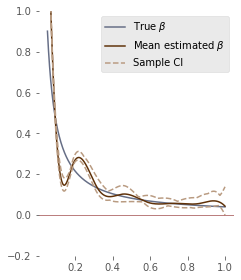

In [20]:
plt.figure(figsize=(3.5,4.5))
plt.plot(T2, betaT2, label = r"True $\beta $", color='#666E86')
plt.plot(T2,mean_fitted_vals, label=r"Mean estimated $\beta $", color='#5F3108')
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='#B99B81', label='Sample CI')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='#B99B81')
# Plot a horizontal line at y=0
plt.axhline(0, color='#780000', linewidth=1)
plt.ylim([-0.2, 1])
plt.legend()
plt.style.use('ggplot')
plt.box(False)
plt.savefig('pareto_cons_0.05.png', transparent=True)
plt.show()

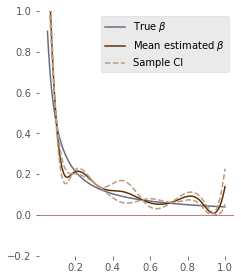

In [11]:
plt.figure(figsize=(3.5,4.5))
plt.plot(T2, betaT2, label = r"True $\beta $", color='#666E86')
plt.plot(T2,mean_fitted_vals, label=r"Mean estimated $\beta $", color='#5F3108')
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='#B99B81', label='Sample CI')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='#B99B81')
# Plot a horizontal line at y=0
plt.axhline(0, color='#780000', linewidth=0.5)
plt.ylim([-0.2, 1])
plt.legend()
plt.style.use('ggplot')
plt.box(False)
plt.savefig('ccccccccccccccccccc.png', transparent=True)
plt.show()

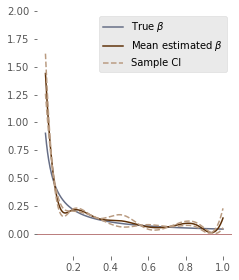

In [15]:
plt.figure(figsize=(3.5,4.5))
plt.plot(T2, betaT2, label = r"True $\beta $", color='#666E86')
plt.plot(T2,mean_fitted_vals, label=r"Mean estimated $\beta $", color='#5F3108')
plt.plot(T2,mean_lower_ci, linestyle='dashed', color='#B99B81', label='Sample CI')
plt.plot(T2,mean_upper_ci, linestyle='dashed', color='#B99B81')
# Plot a horizontal line at y=0
plt.axhline(0, color='#780000', linewidth=0.5)
plt.ylim([-0.2, 2])
plt.legend()
plt.style.use('ggplot')
plt.box(False)
plt.savefig('ccccccccccccccccccc2.png', transparent=True)
plt.show()

In [27]:
imse_cons005_pareto_nonneg_ellos = np.array([0.009413780, 0.010957223, 0.010279801, 0.010396659, 0.009267090, 0.011558180, 0.011252702, 0.010201306, 0.011213332,
0.009940468, 0.009676766, 0.009376192, 0.010821017, 0.011213332, 0.009940468, 0.009676766, 0.009376192, 0.010821017,
0.011213332, 0.009940468, 0.009676766, 0.009376192, 0.010821017, 0.011213332, 0.009940468, 0.009676766, 0.009376192,
0.010821017, 0.011213332, 0.009940468, 0.009676766, 0.009376192, 0.010821017, 0.011213332, 0.009940468, 0.009676766,
0.009376192, 0.010821017, 0.011213332, 0.009940468, 0.009676766, 0.009376192, 0.010821017, 0.011213332, 0.009940468,
0.009676766, 0.009376192, 0.010821017, 0.011213332, 0.009940468, 0.009676766, 0.009376192, 0.010821017, 0.011213332,
0.009940468, 0.009676766, 0.009376192, 0.010821017, 0.011213332, 0.009940468, 0.009676766, 0.009376192, 0.010821017,
0.011213332, 0.009940468, 0.009676766, 0.009376192, 0.010821017, 0.011213332, 0.009940468, 0.009676766, 0.009376192,
0.010821017, 0.011213332, 0.009940468, 0.009676766, 0.009376192, 0.010821017, 0.011213332, 0.009940468, 0.009676766,
0.009376192, 0.010821017, 0.011213332, 0.009940468, 0.009676766, 0.009376192, 0.010821017, 0.011213332, 0.009940468,
0.009676766, 0.009376192, 0.010821017, 0.011213332, 0.009940468, 0.009676766, 0.009376192, 0.010821017, 0.011213332,
0.009940468, 0.009676766, 0.009376192, 0.010821017, 0.011213332, 0.009940468, 0.009676766, 0.009376192, 0.010821017,
0.011213332, 0.009940468, 0.009676766, 0.009376192, 0.010821017, 0.011213332, 0.009940468, 0.009676766, 0.009376192,
0.010821017, 0.011213332, 0.009940468, 0.009676766, 0.009376192, 0.010821017, 0.011213332, 0.009940468, 0.009676766,
0.009376192, 0.010821017, 0.011213332, 0.009940468, 0.009676766, 0.009376192, 0.010821017, 0.011213332, 0.009940468,
0.009676766, 0.009376192, 0.010821017, 0.011213332, 0.009940468, 0.009676766, 0.009376192, 0.010821017, 0.011213332,
0.009940468, 0.009676766, 0.009376192, 0.010821017, 0.011213332, 0.009940468, 0.009676766, 0.009376192, 0.010821017,
0.011213332, 0.009940468, 0.009676766, 0.009376192, 0.010821017, 0.011213332, 0.009940468, 0.009676766, 0.009376192,
0.010821017, 0.011213332, 0.009940468, 0.009676766, 0.009376192, 0.010821017, 0.011213332, 0.009940468, 0.009676766,
0.009376192, 0.010821017, 0.011213332, 0.009940468, 0.009676766, 0.009376192, 0.010821017, 0.011213332, 0.009940468,
0.009676766, 0.009376192, 0.010821017, 0.011213332, 0.009940468, 0.009676766, 0.009376192, 0.010821017, 0.011213332,
0.009940468, 0.009676766, 0.009376192, 0.010821017, 0.011213332, 0.009940468, 0.009676766, 0.009376192, 0.010821017,
0.011213332, 0.009940468,])

imse_uncons005_pareto_nonneg_ellos = np.array([ 0.01534263, 0.02185788, 0.01835384, 0.01537370, 0.03771985, 0.02548303, 0.02126770, 0.02989551 ,0.01801486,
0.03771985, 0.02548303, 0.02126770, 0.02989551, 0.01801486, 0.03771985, 0.02548303, 0.02126770, 0.02989551,
0.01801486, 0.03771985, 0.02548303, 0.02126770, 0.02989551, 0.01801486, 0.03771985, 0.02548303, 0.02126770,
0.02989551, 0.01801486, 0.03771985, 0.02548303, 0.02126770, 0.02989551, 0.01801486, 0.03771985, 0.02548303,
0.02126770, 0.02989551, 0.01801486, 0.03771985, 0.02548303, 0.02126770, 0.02989551, 0.01801486, 0.03771985,
0.02548303, 0.02126770, 0.02989551, 0.01801486, 0.03771985, 0.02548303, 0.02126770, 0.02989551, 0.01801486,
0.03771985, 0.02548303, 0.02126770, 0.02989551, 0.01801486, 0.03771985, 0.02548303, 0.02126770, 0.02989551,
0.01801486, 0.03771985, 0.02548303, 0.02126770, 0.02989551, 0.01801486, 0.03771985, 0.02548303, 0.02126770,
0.02989551, 0.01801486, 0.03771985, 0.02548303, 0.02126770, 0.02989551, 0.01801486, 0.03771985, 0.02548303,
0.02126770, 0.02989551, 0.01801486, 0.03771985, 0.02548303, 0.02126770, 0.02989551, 0.01801486, 0.03771985,
0.02548303, 0.02126770, 0.02989551, 0.01801486, 0.03771985, 0.02548303, 0.02126770, 0.02989551, 0.01801486,
0.03771985, 0.02548303, 0.02126770, 0.02989551, 0.01801486, 0.03771985, 0.02548303, 0.02126770, 0.02989551,
0.01801486, 0.03771985, 0.02548303, 0.02126770, 0.02989551, 0.01801486, 0.03771985, 0.02548303, 0.02126770,
0.02989551, 0.01801486, 0.03771985, 0.02548303, 0.02126770, 0.02989551, 0.01801486, 0.03771985, 0.02548303,
0.02126770, 0.02989551, 0.01801486, 0.03771985, 0.02548303, 0.02126770, 0.02989551, 0.01801486, 0.03771985,
0.02548303, 0.02126770, 0.02989551, 0.01801486, 0.03771985, 0.02548303, 0.02126770, 0.02989551, 0.01801486,
0.03771985, 0.02548303, 0.02126770, 0.02989551, 0.01801486, 0.03771985, 0.02548303, 0.02126770, 0.02989551,
0.01801486, 0.03771985, 0.02548303, 0.02126770, 0.02989551, 0.01801486, 0.03771985, 0.02548303, 0.02126770,
0.02989551, 0.01801486, 0.03771985, 0.02548303, 0.02126770, 0.02989551, 0.01801486, 0.03771985, 0.02548303,
0.02126770, 0.02989551, 0.01801486, 0.03771985, 0.02548303, 0.02126770, 0.02989551, 0.01801486, 0.03771985,
0.02548303, 0.02126770, 0.02989551, 0.01801486, 0.03771985, 0.02548303, 0.02126770, 0.02989551, 0.01801486,
0.03771985, 0.02548303, 0.02126770, 0.02989551, 0.01801486, 0.03771985, 0.02548303, 0.02126770, 0.02989551,
0.01801486, 0.03771985])


mse_cons005_pareto_nonneg_ellos = np.array([ 0.002629304, 0.002649527, 0.002869757 ,0.002734587, 0.002358888, 0.002451654, 0.002644176,0.002872092, 0.002832924,
0.002668866, 0.002485609, 0.002474879, 0.002643007, 0.002832924, 0.002668866, 0.002485609, 0.002474879, 0.002643007,
0.002832924, 0.002668866, 0.002485609, 0.002474879, 0.002643007, 0.002832924, 0.002668866, 0.002485609, 0.002474879,
0.002643007, 0.002832924, 0.002668866, 0.002485609, 0.002474879, 0.002643007, 0.002832924, 0.002668866, 0.002485609,
0.002474879, 0.002643007, 0.002832924, 0.002668866, 0.002485609, 0.002474879, 0.002643007, 0.002832924, 0.002668866,
0.002485609, 0.002474879, 0.002643007, 0.002832924, 0.002668866, 0.002485609, 0.002474879, 0.002643007, 0.002832924,
0.002668866, 0.002485609, 0.002474879, 0.002643007, 0.002832924, 0.002668866, 0.002485609, 0.002474879, 0.002643007,
0.002832924, 0.002668866, 0.002485609, 0.002474879, 0.002643007, 0.002832924, 0.002668866, 0.002485609, 0.002474879,
0.002643007, 0.002832924, 0.002668866, 0.002485609, 0.002474879, 0.002643007, 0.002832924, 0.002668866, 0.002485609,
0.002474879, 0.002643007, 0.002832924, 0.002668866, 0.002485609, 0.002474879, 0.002643007, 0.002832924, 0.002668866,
0.002485609, 0.002474879, 0.002643007, 0.002832924, 0.002668866, 0.002485609, 0.002474879, 0.002643007, 0.002832924,
0.002668866, 0.002485609, 0.002474879, 0.002643007, 0.002832924, 0.002668866, 0.002485609, 0.002474879, 0.002643007,
0.002832924, 0.002668866, 0.002485609, 0.002474879, 0.002643007, 0.002832924, 0.002668866, 0.002485609, 0.002474879,
0.002643007, 0.002832924, 0.002668866, 0.002485609, 0.002474879, 0.002643007, 0.002832924, 0.002668866, 0.002485609,
0.002474879, 0.002643007, 0.002832924, 0.002668866, 0.002485609, 0.002474879, 0.002643007, 0.002832924, 0.002668866,
0.002485609, 0.002474879, 0.002643007, 0.002832924, 0.002668866, 0.002485609, 0.002474879, 0.002643007, 0.002832924,
0.002668866, 0.002485609, 0.002474879, 0.002643007, 0.002832924, 0.002668866, 0.002485609, 0.002474879, 0.002643007,
0.002832924, 0.002668866, 0.002485609, 0.002474879, 0.002643007, 0.002832924, 0.002668866, 0.002485609, 0.002474879,
0.002643007, 0.002832924, 0.002668866, 0.002485609, 0.002474879, 0.002643007, 0.002832924, 0.002668866, 0.002485609,
0.002474879, 0.002643007, 0.002832924, 0.002668866, 0.002485609, 0.002474879, 0.002643007, 0.002832924, 0.002668866,
0.002485609, 0.002474879, 0.002643007, 0.002832924, 0.002668866, 0.002485609, 0.002474879, 0.002643007, 0.002832924,
0.002668866, 0.002485609, 0.002474879, 0.002643007, 0.002832924, 0.002668866, 0.002485609, 0.002474879, 0.002643007,
0.002832924, 0.002668866])


mse_uncons005_pareto_nonneg_ellos = np.array([0.001933100, 0.001821800, 0.001942888, 0.001835204, 0.001514940, 0.001652740 ,0.001809238 ,0.001890667 ,0.001873063,
0.001514940, 0.001652740, 0.001809238, 0.001890667, 0.001873063, 0.001514940, 0.001652740, 0.001809238, 0.001890667,
0.001873063, 0.001514940, 0.001652740, 0.001809238, 0.001890667, 0.001873063, 0.001514940, 0.001652740, 0.001809238,
0.001890667, 0.001873063, 0.001514940, 0.001652740, 0.001809238, 0.001890667, 0.001873063, 0.001514940, 0.001652740,
0.001809238, 0.001890667, 0.001873063, 0.001514940, 0.001652740, 0.001809238, 0.001890667, 0.001873063, 0.001514940,
0.001652740, 0.001809238, 0.001890667, 0.001873063, 0.001514940, 0.001652740, 0.001809238, 0.001890667, 0.001873063,
0.001514940, 0.001652740, 0.001809238, 0.001890667, 0.001873063, 0.001514940, 0.001652740, 0.001809238, 0.001890667,
0.001873063, 0.001514940, 0.001652740, 0.001809238, 0.001890667, 0.001873063, 0.001514940, 0.001652740, 0.001809238,
0.001890667, 0.001873063, 0.001514940, 0.001652740, 0.001809238, 0.001890667, 0.001873063, 0.001514940, 0.001652740,
0.001809238, 0.001890667, 0.001873063, 0.001514940, 0.001652740, 0.001809238, 0.001890667, 0.001873063, 0.001514940,
0.001652740, 0.001809238, 0.001890667, 0.001873063, 0.001514940, 0.001652740, 0.001809238, 0.001890667, 0.001873063,
0.001514940, 0.001652740, 0.001809238, 0.001890667, 0.001873063, 0.001514940, 0.001652740, 0.001809238, 0.001890667,
0.001873063, 0.001514940, 0.001652740, 0.001809238, 0.001890667, 0.001873063, 0.001514940, 0.001652740, 0.001809238,
0.001890667, 0.001873063, 0.001514940, 0.001652740, 0.001809238, 0.001890667, 0.001873063, 0.001514940, 0.001652740,
0.001809238, 0.001890667, 0.001873063, 0.001514940, 0.001652740, 0.001809238, 0.001890667, 0.001873063, 0.001514940,
0.001652740, 0.001809238, 0.001890667, 0.001873063, 0.001514940, 0.001652740, 0.001809238, 0.001890667, 0.001873063,
0.001514940, 0.001652740, 0.001809238, 0.001890667, 0.001873063, 0.001514940, 0.001652740, 0.001809238, 0.001890667,
0.001873063, 0.001514940, 0.001652740, 0.001809238, 0.001890667, 0.001873063, 0.001514940, 0.001652740, 0.001809238,
0.001890667, 0.001873063, 0.001514940, 0.001652740, 0.001809238, 0.001890667, 0.001873063, 0.001514940, 0.001652740,
0.001809238, 0.001890667, 0.001873063, 0.001514940, 0.001652740, 0.001809238, 0.001890667, 0.001873063, 0.001514940,
0.001652740, 0.001809238, 0.001890667, 0.001873063, 0.001514940, 0.001652740, 0.001809238, 0.001890667, 0.001873063,
0.001514940, 0.001652740, 0.001809238, 0.001890667, 0.001873063, 0.001514940, 0.001652740, 0.001809238, 0.001890667,
0.001873063, 0.001514940])

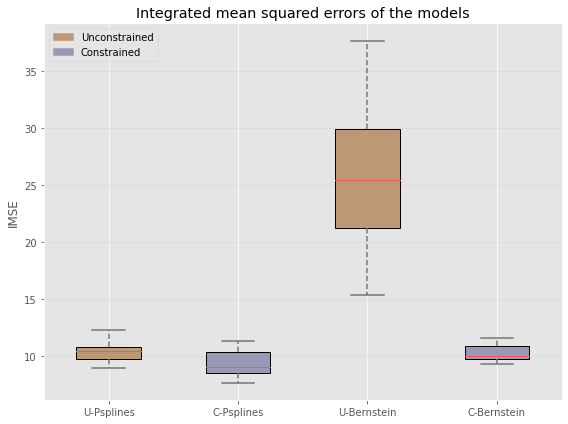

In [28]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Generate random data
np.random.seed(1)


# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Customize boxplot colors
box_colors = ['#BC9874', '#9899B5', '#BC9874', '#9899B5']
box_labels = ['U-Psplines', 'C-Psplines', 'U-Bernstein', 'C-Bernstein']
legend_labels = ['Unconstrained', 'Constrained']
# Create boxplot
boxplot = ax.boxplot([IMSE_uncons*1000, IMSE_cons*1000, imse_uncons005_pareto_nonneg_ellos*1000, imse_cons005_pareto_nonneg_ellos*1000], patch_artist=True, widths=0.5, showfliers=False)

# Set boxplot style
for patch, color in zip(boxplot['boxes'], box_colors):
    patch.set_facecolor(color)

# Set whisker and cap style
for whisker, cap in zip(boxplot['whiskers'], boxplot['caps']):
    whisker.set(color='#757575', linewidth=1.5, linestyle='--')
    cap.set(color='#757575', linewidth=1.5)

# Set median line style
for median in boxplot['medians']:
    median.set(color='#FF5252', linewidth=1)

# Set outliers style
for flier in boxplot['fliers']:
    flier.set(marker='o', markersize=5, markerfacecolor='#FF5252', alpha=0.8)

# Create custom legend
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(box_colors, legend_labels)]
legend_patchess = [legend_patches[0], legend_patches[1]]
ax.legend(handles=legend_patchess, loc='upper left')

# Set axis labels and title
ax.set_xticklabels(box_labels)
ax.set_ylabel('IMSE')
ax.set_title('Integrated mean squared errors of the models')

# Customize grid appearance
ax.yaxis.grid(True, linestyle='--', which='major', color='lightgrey', alpha=0.8)

# Adjust the plot layout
fig.tight_layout()
plt.box(True)
plt.savefig('pareto_nonneg_imse_005.png', transparent=True)
# Show the plot
plt.show()